In [4]:
## Import Libraries
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import openpyxl

pd.set_option("max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split("source_gene=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("source_gene_common_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Only keep relevant
        df = df[["chr", "gene_id", "gene_name"]].copy()

        ## Drop duplicates
        df.drop_duplicates(inplace=True)
        

    else:

        ## Get CHM gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Drop "other" column
        df = df[["chr", "gene_id"]].copy()
        
    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [6]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df):

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in ["total_counts"]:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df 

In [4]:
## Import transcripts
df_transcripts = pd.read_csv("C:/Users/bag22_local/Desktop/programming/ebbert_lab/data/2022-07-14_cDNA_data_ebbert_lab_nextflow_pipeline_output_raw/ONT_only_data/CHM13_good_ONT/bambu_discovery/counts_transcript.txt",
        sep="\t", names=["TXNAME", "GENEID", "sample_PAM54788",
                         "sample_PAM54335", "sample_PAM54401", "sample_PAM54902"], low_memory=False, header=0)

In [5]:
## Import Genes
df_genes = pd.read_csv("C:/Users/bag22/OneDrive - University of Kentucky/Desktop/current_files/python_files/ebbert_lab/data/2022-07-14_cDNA_data_ebbert_lab_nextflow_pipeline_output_raw/ONT_only_data/CHM13_good_ONT/bambu_discovery/counts_gene.txt",
        sep="\t", names=["GENEID", "sample_PAM54788",
                         "sample_PAM54335", "sample_PAM54401", "sample_PAM54902"], low_memory=False, header=0)

In [6]:
## Get total counts for genes and transcripts
df_genes["total_counts"] = df_genes[["sample_PAM54788", "sample_PAM54335", "sample_PAM54401", "sample_PAM54902"]].sum(axis=1)
df_transcripts["total_counts"] = df_transcripts[["sample_PAM54788", "sample_PAM54335", "sample_PAM54401", "sample_PAM54902"]].sum(axis=1)

In [ ]:
## Only keep genes and transcripts with more than 0 counts
df_genes = df_genes.loc[df_genes["total_counts"] > 0].copy()
df_transcripts = df_transcripts.loc[df_transcripts["total_counts"] > 0].copy()

In [7]:
## Calculate percentile
df_genes['percentile'] = df_genes["total_counts"].rank(pct=True)

In [8]:
## Calculate Rank
df_genes['rank'] = df_genes["total_counts"].rank(ascending=False)

In [9]:
## See rank for FTH1
df_genes.loc[df_genes["GENEID"].str.contains("ENSG00000167996")]

,GENEID,sample_PAM54788,sample_PAM54335,sample_PAM54401,sample_PAM54902,total_counts,percentile,rank
12330,ENSG00000167996.16,145489.0,99951.0,24880,40216.0,310536.0,0.999519,32.0


In [10]:
## See rank for FTL
df_genes.loc[df_genes["GENEID"].str.contains("ENSG00000087086")]

,GENEID,sample_PAM54788,sample_PAM54335,sample_PAM54401,sample_PAM54902,total_counts,percentile,rank
1787,ENSG00000087086.15,14613.0,9610.0,12373,14619.0,51215.0,0.995129,315.0


In [11]:
## Get list of genes as expressed or more expressed than FTL
df_top_genes = df_genes.loc[df_genes["rank"] <= 315].copy()

df_top_genes["GENEID"] = df_top_genes["GENEID"].str.split(".", expand=True)[0]

In [12]:
## Import CHM13 GFF
chm_13_annotation = pd.read_csv("C:/Users/bag22/OneDrive - University of Kentucky/Desktop/current_files/python_files/ebbert_lab/cDNA-comparison/article_analysis/annotations/CHM13.v2.0.gff3",
        sep="\t", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], low_memory=False, header=None)

In [13]:
## Only keep gene biotype
chm_13_annotation = chm_13_annotation.loc[chm_13_annotation["type"] == "gene"]

In [14]:
## Parse through CHM13
chm_13_annotation = parse_df_columns(chm_13_annotation, is_ref=True)

In [15]:
## Fix gene_ids
chm_13_annotation["gene_id"] = chm_13_annotation["gene_id"].str.split(".", expand=True)[0]

In [16]:
## Remove duplicate entries and chr column
chm_13_annotation.drop(columns="chr", inplace=True)
chm_13_annotation.drop_duplicates(inplace=True)

In [17]:
## Correct column names
df_top_genes.columns = ['gene_id', 'sample_PAM54788', 'sample_PAM54335', 'sample_PAM54401',
       'sample_PAM54902', 'total_counts', 'percentile', 'rank']

In [18]:
## Get final list of genes with names
final_top_genes = pd.merge(df_top_genes, chm_13_annotation, on="gene_id", how="inner")

In [19]:
## Put name column as first
cols = list(final_top_genes.columns)
cols = [cols[-1]] + cols[:-1]
final_top_genes = final_top_genes[cols]

In [20]:
## Save list of top expressed genes
final_top_genes.to_excel("C:/Users/bag22/OneDrive - University of Kentucky/Desktop/highly_expressed_genes_RNAseq_aged_brain_samples.xlsx", index=False)

In [21]:
## Get total counts for all genes with more than 0 counts
total_counts = df_genes["total_counts"]

In [22]:
## Get log total counts
log_total_counts = np.log10(df_genes["total_counts"])

In [23]:
## Use ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

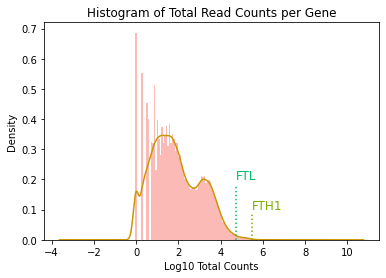

In [24]:
## Create log plot

fig, ax = plt.subplots(figsize = (6,4))


log_total_counts.plot(kind = "hist", density = True, bins = 100, color="#F8766D", alpha=0.5) # change density to true, because KDE uses density


log_total_counts.plot(kind = "kde", color="#CD9600", alpha=1)

ax.set_xlabel("Log10 Total Counts")


ax.set_title("Histogram of Total Read Counts per Gene")

ax.axvline(5.492, alpha=1, ymax = 0.12, linestyle = ":", color="#7CAE00")
ax.axvline(4.709, alpha=1, ymax = 0.25, linestyle = ":", color="#00BE67")


ax.text(5.492, 0.10, "FTH1", size = 12, alpha = 1, color="#7CAE00")
ax.text(4.709, 0.20, "FTL", size = 12, alpha = 1, color="#00BE67")


plt.show()

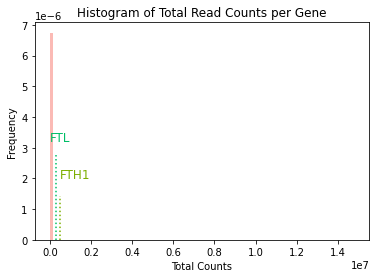

In [25]:
## Create total counts plot

fig, ax = plt.subplots(figsize = (6,4))

total_counts.plot(kind = "hist", density = True, bins = 100, color="#F8766D", alpha=0.5) # change density to true, because KDE uses density

ax.set_xlabel("Total Counts")

ax.set_title("Histogram of Total Read Counts per Gene")

ax.axvline(512150.0, alpha=1, ymax = 0.2, linestyle = ":", color="#7CAE00")
ax.axvline(310536.0, alpha=1, ymax = 0.4, linestyle = ":", color="#00BE67")

ax.text(512150.0, 0.000002, "FTH1", fontsize = 12, alpha = 1, color="#7CAE00")
ax.text(0, 0.0000032, "FTL", fontsize = 12, alpha = 1, color="#00BE67")

plt.show()

In [53]:
## Import extended annotation
gtf = pd.read_csv("C:/Users/bag22/OneDrive - University of Kentucky/Desktop/current_files/python_files/ebbert_lab/data/2022-07-14_cDNA_data_ebbert_lab_nextflow_pipeline_output_raw/ONT_only_data/CHM13_good_ONT/bambu_discovery/extended_annotations.gtf",
        sep="\t", names=["chr", "source", "type", "start", 
                               "end", "dot_1", "strand", "dot_2", "other"], low_memory=False, header=0)

In [54]:
## Parse through it
gtf = parse_df_columns(gtf, is_ref=False)

In [55]:
## Get gene ids for mitochondrial genes
gtf_mito_ids = gtf.loc[gtf["chr"] == "chrM"]["gene_id"]

In [ ]:
## Select only nuclear genes
df_genes_nuclear = df_genes.loc[~df_genes["GENEID"].isin(gtf_mito_ids)]

In [ ]:
## Total counts for nuclear genes
total_counts_nuclear = df_genes_nuclear["total_counts"]

In [ ]:
## Make graph for nuclear genes
fig, ax = plt.subplots(figsize = (6,4))

total_counts_nuclear.plot(kind = "hist", density = True, bins = 100, color="#F8766D", alpha=0.5) # change density to true, because KDE uses density

ax.set_xlabel("Total Counts")

ax.set_title("Histogram of Total Read Counts per Gene (Autosomal Only)")

ax.axvline(512150.0, alpha=1, ymax = 0.2, linestyle = ":", color="#7CAE00")
ax.axvline(310536.0, alpha=1, ymax = 0.4, linestyle = ":", color="#00BE67")

ax.text(512150.0, 0.000025, "FTH1", fontsize = 12, alpha = 1, color="#7CAE00")
ax.text(310536.0, 0.000050, "FTL", fontsize = 12, alpha = 1, color="#00BE67")

plt.show()

#####################################################################################################

In [68]:
## Look at Ferroportin expression
df_transcripts.loc[df_transcripts["GENEID"].str.contains("ENSG00000138449")]

,TXNAME,GENEID,sample_PAM54788,sample_PAM54335,sample_PAM54401,sample_PAM54902
6757,ENST00000261024.7,ENSG00000138449.11,4.420000e+02,1.680000e+02,241.0,132.0
47124,ENST00000418714.1,ENSG00000138449.11,0.000000e+00,1.530325e-08,0.0,0.0
52651,ENST00000427241.5,ENSG00000138449.11,0.000000e+00,5.000000e+00,0.0,0.0
52770,ENST00000427419.5,ENSG00000138449.11,0.000000e+00,0.000000e+00,0.0,0.0
61204,ENST00000440626.1,ENSG00000138449.11,0.000000e+00,0.000000e+00,0.0,0.0
70623,ENST00000455320.5,ENSG00000138449.11,3.000000e+00,0.000000e+00,3.0,0.0
89087,ENST00000479598.5,ENSG00000138449.11,4.805040e-07,2.000000e+00,0.0,0.0


In [69]:
## Look at SORL1 Expression
df_transcripts.loc[df_transcripts["GENEID"].str.contains("ENSG00000137642")]

,TXNAME,GENEID,sample_PAM54788,sample_PAM54335,sample_PAM54401,sample_PAM54902
6662,ENST00000260197.12,ENSG00000137642.13,4.193441e+03,2608.847780,2.211197e+03,2.617585e+03
124839,ENST00000524633.1,ENSG00000137642.13,3.000000e+00,2.029619,9.794938e-08,1.351915e-08
125059,ENST00000524873.1,ENSG00000137642.13,1.900000e+01,11.000000,0.000000e+00,0.000000e+00
125673,ENST00000525532.5,ENSG00000137642.13,1.023910e+00,69.945087,7.259449e+00,1.473860e+01
127639,ENST00000527649.1,ENSG00000137642.13,5.000000e-15,4.027097,0.000000e+00,1.011821e+00
127895,ENST00000527934.1,ENSG00000137642.13,1.635906e+01,7.140193,1.129565e+01,5.242173e-08
128275,ENST00000528339.5,ENSG00000137642.13,2.007526e+00,0.000000,3.004167e+00,3.830690e-10
129303,ENST00000529445.1,ENSG00000137642.13,0.000000e+00,0.000000,0.000000e+00,1.000000e+00
130162,ENST00000530365.1,ENSG00000137642.13,1.000000e+00,2.000000,0.000000e+00,2.002545e+00
132090,ENST00000532451.1,ENSG00000137642.13,1.511025e+01,0.000012,1.323708e+01,3.503261e+00


In [108]:
## Look at MAPT expression
df_transcripts.loc[df_transcripts["GENEID"].str.contains("ENSG00000186868")]

,TXNAME,GENEID,sample_PAM54788,sample_PAM54335,sample_PAM54401,sample_PAM54902,total_counts
7105,ENST00000262410.10,ENSG00000186868.16,1229.401379,132.079780,419.774088,181.096197,1962.351444
16008,ENST00000334239.12,ENSG00000186868.16,111.920591,66.901024,203.513982,37.946063,420.281660
18086,ENST00000344290.10,ENSG00000186868.16,3.232433,0.000000,11.309986,0.000000,14.542419
18934,ENST00000351559.10,ENSG00000186868.16,4951.058717,2108.063607,6474.052787,1825.480960,15358.656071
45145,ENST00000415613.6,ENSG00000186868.16,7.063860,1.074627,2.033702,0.000000,10.172189
48366,ENST00000420682.6,ENSG00000186868.16,16.064805,6.033803,5.037459,8.237091,35.373158
55056,ENST00000431008.7,ENSG00000186868.16,8.052603,2.096739,8.029215,3.263369,21.441925
64866,ENST00000446361.7,ENSG00000186868.16,2707.726833,2487.716516,4100.357920,3353.251931,12649.053200
134875,ENST00000535772.6,ENSG00000186868.16,183.601699,90.819692,222.680822,53.139785,550.241997
160874,ENST00000570299.5,ENSG00000186868.16,0.000000,2.051263,4.051513,0.000000,6.102776


In [108]:
## Look at Clusterin (CLU) expression
df_transcripts.loc[df_transcripts["GENEID"].str.contains("ENSG00000120885")]

,TXNAME,GENEID,sample_PAM54788,sample_PAM54335,sample_PAM54401,sample_PAM54902
13308,ENST00000316403.15,ENSG00000120885.22,299005.031269,99565.549273,3.006913e+05,1.548896e+05
39912,ENST00000405140.7,ENSG00000120885.22,5484.674587,2777.321646,3.807771e+03,4.143302e+03
118686,ENST00000518050.1,ENSG00000120885.22,16.821212,120.374549,6.641111e+01,1.548875e+03
120007,ENST00000519472.5,ENSG00000120885.22,98.025026,33.798982,1.430566e+02,4.068544e+01
120267,ENST00000519742.5,ENSG00000120885.22,4.033952,0.000000,2.106277e+00,1.011115e+00
120965,ENST00000520491.5,ENSG00000120885.22,2.016976,0.000000,3.020908e+00,2.022230e+00
121257,ENST00000520796.5,ENSG00000120885.22,19.146354,10.096437,2.428151e+01,1.310521e+01
122181,ENST00000521770.1,ENSG00000120885.22,97.426858,54.398256,2.026228e+02,1.126097e+02
122487,ENST00000522098.1,ENSG00000120885.22,34.058549,10.023001,6.703554e+01,3.920994e+01
122619,ENST00000522238.1,ENSG00000120885.22,63.004506,80.007390,9.001450e+00,4.901399e+01


In [110]:
## Look at Ferritin Heavy Chain Expression (FTH1)
df_transcripts.loc[df_transcripts["GENEID"].str.contains("ENSG00000167996")]

,TXNAME,GENEID,sample_PAM54788,sample_PAM54335,sample_PAM54401,sample_PAM54902
8541,ENST00000273550.12,ENSG00000167996.16,1.422830e+05,97437.056480,2.053134e+04,37720.533750
126687,ENST00000526640.5,ENSG00000167996.16,3.811466e+02,396.190378,3.519018e+02,227.150950
129068,ENST00000529191.5,ENSG00000167996.16,3.060000e-14,0.000000,1.831165e-09,0.000000
129400,ENST00000529548.1,ENSG00000167996.16,3.272378e+00,2.047330,3.009827e+00,1.001352
129479,ENST00000529631.5,ENSG00000167996.16,2.012864e+00,0.000000,4.013222e+00,2.003443
129846,ENST00000530019.5,ENSG00000167996.16,3.019959e+00,5.010972,2.007195e+00,0.000000
132226,ENST00000532601.1,ENSG00000167996.16,6.010644e+00,18.016406,4.106343e+01,34.020989
132430,ENST00000532829.5,ENSG00000167996.16,8.993973e+02,671.438055,1.384167e+02,289.449451
132720,ENST00000533138.1,ENSG00000167996.16,3.620060e+01,33.024827,1.301070e+01,25.018105
133686,ENST00000534180.1,ENSG00000167996.16,7.679798e+01,57.705895,8.703509e+01,45.273465


In [111]:
## Look at Ferritin Light Chain Expression (FTL)
df_transcripts.loc[df_transcripts["GENEID"].str.contains("ENSG00000087086")]

,TXNAME,GENEID,sample_PAM54788,sample_PAM54335,sample_PAM54401,sample_PAM54902
15599,ENST00000331825.11,ENSG00000087086.15,14613.0,9610.0,12373.0,14619.0
